# MBA em Ciência de Dados
# Técnicas Avançadas de Captura e Tratamento de Dados

### <span style="color:darkred">Dados estruturados e não estruturados e problemas típicos em bases de dados</span>


## <span style="color:darkred">Outliers, ruído e dados incorretos/erros</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

--- 

![outlier](imagens/outlier.jpg)

**Outliers, dados incorretos e ruído** são também frequentes em bases de dados.

* *outlier* é um dado que recai fora da distribuição principal dos dados
* *incorreto* é aquele que existe na base de dados (não é faltante), mas também não se encaixa naquela variável ou atributo de entrada, e deve ser corrigido ou removido
* *ruído* é um dado que atrapalha a análise, dificultando encontrar padrões nos dados

Os conceitos tem uma diferença tênue. Buscar por esse tipo de dado e estudar forma de compensar sua existência, corrigindo-os ou removendo-os é parte do tratamento de dados.

---
Utilizaremos um conjunto de dados de natalidade em uma maternidade, e que contém os seguintes atributos relativos aos nascidos:
* sexo, 
* peso do nascimento (em gramas), 
* idade gestacional (em semanas),
* mês do nascimento,
* ano do nascimento.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv("./dados/TACTD-01-Outliers_Erros_Desbal.csv")

print("Número de observacoes na base de dados: ", data.shape[0])
data.head(3)

Número de observacoes na base de dados:  72


,Sex,Weight,Gestational age,Month,Year
0,F,3490,38,12,2016
1,M,3650,39,12,2016
2,M,2740,34,12,2016


## Erros

São dados que possuem problemas provavelmente durante algum processo na entrada, transmissão ou armazenamento, em que a validação dos dados falhou.

Uma forma é inspecionar os valores únicos das variáveis/colunas

In [172]:
for var in data:
    print('Coluna:', var, 'Tipo:', data[var].dtype)
    print(data[var].unique(), '\n')

Coluna: Sex Tipo: object
['F' 'M' 'P'] 

Coluna: Weight Tipo: int64
[3490 3650 2740 3380 3820 2790 1850 3270 2800 3470 3200 3720 3730 3550
 2780 3600 3610 2200 3680 3570 3980 3300 3860 3120 3460 3130 3690 2950
 3790 3230 2500 2920 3050 4300 3580 4900 2940 3220 3480 3540 3640 3700
 2880 3750 4000 3880 4150 3800 3100 3280 4100 3900 3450] 

Coluna: Gestational age Tipo: int64
[38 39 34 36 35 40 37 41 33 42 43 32] 

Coluna: Month Tipo: int64
[12  1  2  3  4  5] 

Coluna: Year Tipo: int64
[ 2016 22017  2017] 



Dados errôneos encontrados:
1. Sexo = P

2. Ano = 22017


O valor **P** não pertence ao que é esperado. Esse dado foi corrompido de alguma forma e representa um dado **incorreto**. Devemos desconsiderá-lo, tornando-o um dado faltante.

O valor **22017** é recuperável, corrigindo para 2017 que é com grande chance o dado correto

In [173]:
# defininos o dado P como sendo faltante
data.loc[data['Sex']=='P', 'Sex'] = np.nan

# corrigimos o 22017
data.loc[data['Year']==22017, 'Year'] = 2017

## *Outliers* 


#### Tipos de *outliers*

Também chamados de pontos "fora-da-curva" ou aberrantes. 

Os pontos *não-outliers* são às vezes chamados de *inliers* pois recaem "dentro" do esperado.

Tipos de outliers incluem : 

1. Globais ou anomalias de ponto

2. Contextuais ou condicionais

3. Coletivos

---


1. **Globais ou anomalias de ponto**: são ocorrências de valores *individuais* muito diferentes da maior parte dos dados disponíveis.

    Uma forma simples de identificar é gerar gráficos de caixa (ou *boxplots*) dos atributos/colunas da base de dados. 
    
    Esse gráfico exibe:
        * o intervalo dos valores que representam 50% do total dos dados dentro de uma caixa
        * a mediana como uma linha dentro da caixa
        * "whiskers" ou bigodes que indicam a dispersão de 1,5 vezes o Intervalo Interquartil (IQR) com relação às bordas das caixas


![boxplot](imagens/boxplot.png)

       
    
Idealmente, grafamos cada variável individualmente, pois elas têm intervalos de valores distintos! 
* por exemplo, enquanto o peso está definido ao redor de milhares de gramas, a idade gestacional é em dezenas de semanas

<AxesSubplot:>

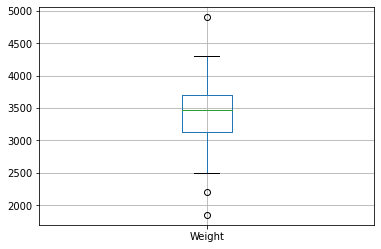

In [174]:
data.boxplot(column=['Weight'])

Notamos que a maior parte dos pesos recaem aproximadamente entre 2500 e 4400, mas temos alguns pontos fora desse intervalo. Vamos tentar encontrá-los:

In [175]:
data[(data['Weight'] < 2500) | (data['Weight'] > 4400)]

,Sex,Weight,Gestational age,Month,Year
6,M,1850,38,12,2016
19,F,2200,33,1,2017
41,F,4900,42,3,2017


Há valores mais altos ou mais baixos do que a maioria. Nesses casos, parecem ser valores inputados corretamente e verdadeiros. 

Por desviar da maior parte dos dados são considerados **outliers globais**.

No entanto, não iremos removê-lo a princípio pois são factíveis e não é possível dizer que são incorretos.

---

2. **Contextuais**: são valores que, observados isoladamente podem não ser aberrantes, mas que ao observar o <u>contexto</u>, sim!

    * Em dados **independentes e identicamente distribuídos**, na qual um exemplo (nascimento de um bebê e seus dados) não deveria afetar os próximos exemplos observados, o contexto pode estar nas variáveis envolvidas.
    
    * Em dados **sequenciais** (como séries temporais, texto), em que uma observação influencia a próxima, o contexto é quase sempre o aspecto temporal/sequencial.
    
No nosso exemplo, podemos observar se há uma anomalia de peso com relação à idade gestacional!

Considere que sabemos, por meio de um especialista que:
* bebês nascidos entre 38 e 42 semanas possuem peso normal se estiverem aproximadamente entre 2500 e 4000 gramas.
    
    Assim, podemos buscar por **outliers contextuais**, em que o peso saia fora desse intervalo <u>dentro do período gestacional</u> indicado.
    
    Podemos usar busca por fatiamento da base, e também *boxplots*

In [4]:
#cria visão do dataframe com base na idade gestacional
d_term = data[(data['Gestational age'] >= 38) & (data['Gestational age'] <= 42)]

# buscando por anomalias contextuais por limiar
d_term[ (d_term['Weight'] < 2500) | (d_term['Weight'] > 4000)]

,Sex,Weight,Gestational age,Month,Year
6,M,1850,38,12,2016
41,F,4900,42,3,2017
62,F,4150,41,5,2017


<AxesSubplot:>

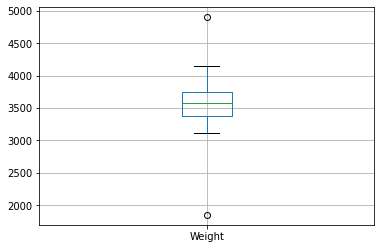

In [177]:
# usando boxplot
d_term.boxplot(column=['Weight'])

É interessante notar que nossa busca específica retornou 3 enquanto o *boxplot* apenas 2 elementos como outliers

Vamos inspecionar os casos segundo o critério do especialista:

In [178]:
d_term[ (d_term['Weight'] < 2000)]

,Sex,Weight,Gestational age,Month,Year
6,M,1850,38,12,2016


Aqui, segundo as diretrizes indicadas por um especialista, é provável que temos um outlier contextual, ou seja, considerando qualquer idade gestacional não seria um outlier, mas se levarmos em conta que foram 38 semanas, então é um outlier.

Quanto ao segundo caso:

In [180]:
d_term[ (d_term['Weight'] > 4000)]

,Sex,Weight,Gestational age,Month,Year
41,F,4900,42,3,2017
62,F,4150,41,5,2017


Aqui, temos um caso limítrofe (4150) e precisamos da ajuda de especialistas para decidir o que significa esse *outlier*

Já 4900 parece ser outlier ainda que também possível dentro dos limites esperados.


--- 

3. **Coletivos**: um conjunto de observacões cujos valores, quando analisados em grupo, indicam um evento não usual.

    Em geral:
    * não são *outliers globais* pois seus valores recaem dentro da maior parte dos dados globalmente
    
    * não são *outliers contextuais* pois individualmente podem ser considerados normais quando observados contextos relevantes

No nosso exemplo, vamos analisar os dados relativos ao nascimento de bebês do sexo masculino e feminino, mês a mês.

In [181]:
data.groupby(['Year','Month'])['Sex'].describe()

count unique top freq
Year Month                      
2016 12       12      2   F    8
2017 1        14      2   F    9
     2        12      2   F    7
     3        11      2   F    9
     4        10      2   F    8
     5        12      1   F   12

Observando a estatística descritiva acima, veja que no mês 5 há 12 ocorrências, mas apenas um único valor, **F**

Vamos visualizar:


In [182]:
data[data['Month'] == 5]

,Sex,Weight,Gestational age,Month,Year
60,F,3120,34,5,2017
61,F,3380,37,5,2017
62,F,4150,41,5,2017
63,F,3800,42,5,2017
64,F,3100,37,5,2017
65,F,3280,40,5,2017
66,F,4000,38,5,2017
67,F,4100,37,5,2017
68,F,3900,40,5,2017
69,F,3450,37,5,2017


De fato, observar apenas nascimento de bebês do sexo feminino em um determinado mês é um **outlier coletivo**.

Note que os valores de sexo e mês individualmente não indicam **outlier global**, e que, quando analisamos observacoes uma a uma, é normal que um bebê do sexo feminino nasca no mês 5, então também a análise individual não mostra **outlier contextual**.

Assim, apenas pela análise conjunta identificamos um comportamento de **outlier**.

--- 
## Ruído

Talvez o mais desafiador dos problemas mencionados, pode ser detectado como outlier ou até mesmo como inlier, mas que representam uma quebra de padrões, dificultando a modelagem do problema.

Por exemplo, suponha que queremos fazer uma modelagem do peso com relação à idade gestacional

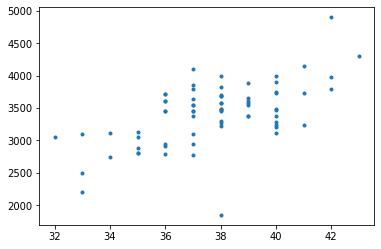

In [183]:
plt.plot(data['Gestational age'], data['Weight'], '.')

É possível identificar pontos que são outliers, mas que representam o padrão esperado: bebês com maior idade gestacional possuem maior peso.

No entanto, notamos que com 38 semanas há um bebê com um peso muito baixo. Esse dado é provavelmente **ruidoso**, ou seja, mesmo que real e não incorreto, levá-lo em consideração para encontrar padrões poderia prejudicar a análise.

In [193]:
data_clean = data[data['Weight'] > 1900 ]
data_clean.shape

(71, 5)

---
## Resumo

* Reconhecer outliers pode ser muito útil para entender os dados, e isso pode levar a diferentes aplicações:
    * detectar dados errôneos
    * detectar anomalias que possam ser reportadas
* É preciso ter conhecimento do domínio para ir além dos outliers globais, capturando também os contextuais e coletivos.
* Erros podem ou não ser passíveis de correção
* Ruído são dados que atrapalhariam análises e devemos considerar remover